# Jeu de données avec des catégories

Le jeu de données [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) ne contient presque que des catégories. Ce notebook explore différentes moyens de les traiter.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_adult_dataset
train, test = load_adult_dataset(url="copy")
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
label = '<=50K'
set(train[label])

{'<=50K', '>50K'}

In [4]:
set(test[label])

{'<=50K', '>50K'}

In [5]:
X_train = train.drop(label, axis=1)
y_train = train[label] == '>50K'
X_test = test.drop(label, axis=1)
y_test = test[label] == '>50K'

In [6]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
<=50K             object
dtype: object

On garde la liste des variables catégorielles.

In [7]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

On les encode [OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html?highlight=onehotencoder#category_encoders.one_hot.OneHotEncoder).

In [8]:
from category_encoders import OneHotEncoder
ce = OneHotEncoder(cols=cat_col, handle_unknown='ignore')

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(ce, LogisticRegression())

In [10]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='ignore', impute_missing=True,
       return_df=True, verbose=0)), ('logisticregression', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [11]:
pipe.score(X_test, y_test)

0.7995823352373933

On essaye avec une [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [12]:
from sklearn.ensemble import RandomForestClassifier
pipe2 = make_pipeline(ce, RandomForestClassifier())
pipe2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='ignore', impute_missing=True,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [13]:
pipe2.score(X_test, y_test)

0.8442356120631411

In [14]:
pipe2.steps[-1][-1].feature_importances_[:5]

array([0.00434022, 0.00822793, 0.01072093, 0.00528915, 0.00653235])

On regarde l'importance des features.

In [15]:
cols = []
for co in X_train.columns:
    if co in cat_col:
        ind = cat_col.index(co)
        mapping = pipe2.steps[0][-1].category_mapping[ind]['mapping']
        for m in mapping:
            cols.append(co + "/" + m[0].strip())
    else:
        cols.append(co)
cols[:5]

['age',
 'workclass/State-gov',
 'workclass/Self-emp-not-inc',
 'workclass/Private',
 'workclass/Federal-gov']

In [16]:
import pandas
df = pandas.DataFrame(dict(name=cols, importance=pipe2.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
df.head()

,importance
name,
native_country/Vietnam,0.162461
native_country/Nicaragua,0.146642
education/12th,0.103415
native_country/Holand-Netherlands,0.083780
native_country/Ireland,0.082138


Text(0.5,1,'Importance des variables')

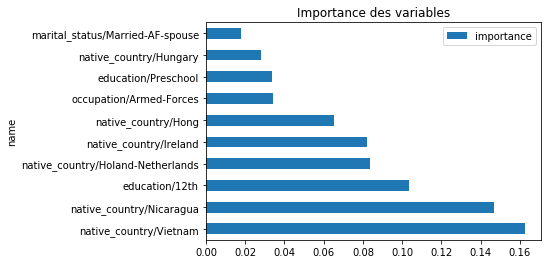

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables')

Ces résultats sont assez surprenants. On regarde un peu plus en détail.

In [18]:
ce = pipe2.steps[0][-1]
ce_train = ce.transform(X_train)
desc = ce_train.describe()
desc.columns = cols
country = desc[[c for c in desc.columns if 'Hong' in c or 'Vietnam' in c or 'Hungary' in c or 'Ireland' in c]]
country.T

,count,mean,std,min,25%,50%,75%,max
native_country/Vietnam,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
native_country/Hong,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
native_country/Ireland,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
native_country/Hungary,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0


In [19]:
ce_train.columns = cols
ce_train.head()

,age,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,...,native_country/Outlying-US(Guam-USVI-etc),native_country/Scotland,native_country/Trinadad&Tobago,native_country/Greece,native_country/Nicaragua,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,39,77516,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,50,83311,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,38,215646,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,53,234721,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,28,338409,13,0,0,40


In [20]:
X_train[['native_country', 'age']].groupby('native_country').count()

,age
native_country,
?,583
Cambodia,19
Canada,121
China,75
Columbia,59
Cuba,95
Dominican-Republic,70
Ecuador,28
El-Salvador,106


In [21]:
res = OneHotEncoder(cols=['native_country']).fit_transform(X_train[['native_country']])
res.head()

,native_country_0,native_country_1,native_country_2,native_country_3,native_country_4,native_country_5,native_country_6,native_country_7,native_country_8,native_country_9,...,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,native_country_-1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
res.describe().T

,count,mean,std,min,25%,50%,75%,max
native_country_0,32561.0,0.895857,0.305451,0.0,1.0,1.0,1.0,1.0
native_country_1,32561.0,0.002918,0.053937,0.0,0.0,0.0,0.0,1.0
native_country_2,32561.0,0.002488,0.049815,0.0,0.0,0.0,0.0,1.0
native_country_3,32561.0,0.003071,0.055334,0.0,0.0,0.0,0.0,1.0
native_country_4,32561.0,0.017905,0.132608,0.0,0.0,0.0,0.0,1.0
native_country_5,32561.0,0.019748,0.139134,0.0,0.0,0.0,0.0,1.0
native_country_6,32561.0,0.002457,0.049507,0.0,0.0,0.0,0.0,1.0
native_country_7,32561.0,0.003501,0.059068,0.0,0.0,0.0,0.0,1.0
native_country_8,32561.0,0.000399,0.019978,0.0,0.0,0.0,0.0,1.0
native_country_9,32561.0,0.002764,0.052502,0.0,0.0,0.0,0.0,1.0


J'ai l'impression qu'il y a un petit bug.